# Data clean - preparation - MyImmo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Téléchargement des fichiers csv

In [2]:
import urllib.request
def download_files_etalab():
  years_files = ['2014', '2015', '2016', '2017', '2018', '2019', '2020']
  for year in years_files:
    url_files = "https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/" + year + "/full.csv.gz"
    name_file = "full-" + year +".csv.gz"
    path_file = '/home/' + name_file
    urllib.request.urlretrieve(url_files, path_file)

In [3]:
download_files_etalab()

### Traitement sur les données

In [2]:
import pandas as pd
import os

Import des fichiers

In [5]:
def import_files_in_dict(year):
  path_file = '/home/full-' + year + '.csv.gz'
  df = pd.read_csv(path_file, compression='gzip')
  return df

Clean data

In [6]:
def clean_data(df):
  df = df[ (df['nature_mutation'] == 'Vente') | (df['nature_mutation'] == "Vente en l'état futur d'achèvement")]
  df = df[ (df['valeur_fonciere'].notna()) & (df['valeur_fonciere'] != 0)]
  df = df[ (df['surface_reelle_bati'].notna()) & (df['surface_reelle_bati'] != 0)]
  df = df[ (df['longitude'].notna())]
  df = df[ (df['latitude'].notna()) ]
  df = df[ (df['nombre_lots'] == 0) ]
  df = df[ (df['code_departement'].notna()) ]
  return df

Traitement sur les données


In [7]:
file_regions = "/content/drive/MyDrive/departments.csv"
regions = pd.read_csv(file_regions)

In [8]:
def group_by_data(df):
  col_gp = ['id_mutation', 'date_mutation', 'nature_mutation', 'code_postal', 'code_commune', 'code_region', 'code_departement',
            'type_local', 'latitude', 'longitude']
  return df.groupby(col_gp, as_index=False).agg( { 'valeur_fonciere': 'max', 'surface_reelle_bati': 'max', 'nombre_pieces_principales': 'max'})

In [9]:
output_data = ['id_mutation', 'date_mutation', 'nature_mutation',
               'valeur_fonciere', 'code_postal', 'code_commune', 'code_region',
               'code_departement', 'code_type_local', 'type_local',
               'surface_reelle_bati', 'nombre_pieces_principales', 'latitude', 'longitude']
years_files = ['2015', '2016', '2017', '2018', '2019', '2020']

df_immo = [] 
for year in years_files:
  df = import_files_in_dict(year)
  df["code_departement"] = df["code_departement"].astype(str)
  df["code_departement"] = df["code_departement"].apply(lambda x: '0' + x if len(x)==1 else x)
  df = pd.merge(df, regions, how='left', left_on='code_departement', right_on='code')
  df["code_region"] = df["region_code"]
  df_clean = clean_data(df)
  df_clean = df_clean[output_data]
  df_clean = group_by_data(df_clean)
  df_clean["prix_metre_carre"] = (df_clean['valeur_fonciere']/df_clean['surface_reelle_bati']).apply(lambda x: round(x))
  df_clean = df_clean.sort_values(['code_region', 'latitude','longitude'])
  if len(df_immo) == 0:
    df_immo = df_clean
  else:
    df_immo = pd.concat([df_immo, df_clean])
df_immo

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10,12,14,16,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10,12,14,16,17,18,20,22,24,26,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10,12,14,16,17,18,20,22,26,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-pa

,id_mutation,date_mutation,nature_mutation,code_postal,code_commune,code_region,code_departement,type_local,latitude,longitude,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,prix_metre_carre
41061,2015-1131554,2015-06-25,Vente,97136.0,97130,01,971,Maison,15.848188,-61.644636,1860.0,90.0,4.0,21
41070,2015-1131605,2015-07-08,Vente,97136.0,97130,01,971,Appartement,15.848572,-61.644027,1570.0,37.0,2.0,42
41071,2015-1131605,2015-07-08,Vente,97136.0,97130,01,971,Maison,15.848572,-61.644027,1570.0,98.0,4.0,16
41226,2015-1132114,2015-12-23,Vente,97136.0,97130,01,971,Maison,15.848833,-61.643867,1450.0,148.0,5.0,10
41013,2015-1131405,2015-04-09,Vente,97137.0,97131,01,971,Maison,15.862501,-61.597274,720000.0,88.0,3.0,8182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84426,2020-227595,2020-12-31,Vente,20600.0,2B120,94,2B,Maison,42.649121,9.443310,375000.0,138.0,5.0,2717
84423,2020-227568,2020-11-16,Vente,20200.0,2B353,94,2B,Maison,42.714854,9.427883,180000.0,104.0,3.0,1731
84425,2020-227575,2020-12-17,Vente,20200.0,2B305,94,2B,Maison,42.733560,9.460780,123500.0,33.0,1.0,3742
84422,2020-227564,2020-10-14,Vente,20233.0,2B224,94,2B,Maison,42.840266,9.456825,265000.0,82.0,4.0,3232


In [10]:
len(df_immo)

3071019

Sauvegarde du fichier clean et preparer

In [ ]:
save_file_path = "/content/drive/MyDrive/dataset-myimmo.csv"
df_immo.to_csv(path_or_buf=save_file_path,index=False,header=True)

Modele BallTree - prix moyen du voisinage

In [ ]:
pd.pivot_table(df_immo, values='valeur_fonciere', index=['type_local'],columns=['nature_mutation'], aggfunc=lambda x: len(x))

nature_mutation,Vente,Vente en l'état futur d'achèvement
type_local,,
Appartement,146391.0,123.0
Dépendance,67.0,1.0
Local industriel. commercial ou assimilé,208140.0,417.0
Maison,2712117.0,3763.0


On creer un ensemble de modele pour les appartements et les maison 

In [11]:
# Appartement
df_immo_appart = df_immo[ (df_immo["nature_mutation"]=="Vente") & (df_immo["type_local"]=="Appartement") ]
# Maison
df_immo_maison = df_immo[ (df_immo["nature_mutation"]=="Vente") & (df_immo["type_local"]=="Maison") ]
df_immo_maison

,id_mutation,date_mutation,nature_mutation,code_postal,code_commune,code_region,code_departement,type_local,latitude,longitude,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,prix_metre_carre
41061,2015-1131554,2015-06-25,Vente,97136.0,97130,01,971,Maison,15.848188,-61.644636,1860.00,90.0,4.0,21
41071,2015-1131605,2015-07-08,Vente,97136.0,97130,01,971,Maison,15.848572,-61.644027,1570.00,98.0,4.0,16
41226,2015-1132114,2015-12-23,Vente,97136.0,97130,01,971,Maison,15.848833,-61.643867,1450.00,148.0,5.0,10
41013,2015-1131405,2015-04-09,Vente,97137.0,97131,01,971,Maison,15.862501,-61.597274,720000.00,88.0,3.0,8182
41225,2015-1132113,2015-12-30,Vente,97137.0,97131,01,971,Maison,15.862801,-61.586874,10671.43,38.0,3.0,281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84426,2020-227595,2020-12-31,Vente,20600.0,2B120,94,2B,Maison,42.649121,9.443310,375000.00,138.0,5.0,2717
84423,2020-227568,2020-11-16,Vente,20200.0,2B353,94,2B,Maison,42.714854,9.427883,180000.00,104.0,3.0,1731
84425,2020-227575,2020-12-17,Vente,20200.0,2B305,94,2B,Maison,42.733560,9.460780,123500.00,33.0,1.0,3742
84422,2020-227564,2020-10-14,Vente,20233.0,2B224,94,2B,Maison,42.840266,9.456825,265000.00,82.0,4.0,3232


Modele BallTree pour les appartements - 1 modéle par region

In [10]:
from sklearn.neighbors import BallTree
import numpy as np
import time

In [ ]:
df_immo_maison['distance_moyenne']=np.zeros(len(df_immo_maison))
df_immo_maison['index_voisins']=np.zeros(len(df_immo_maison))
models = {}
regions = df_immo_maison.code_region.unique()
for k in range(len(regions)):
    name = 'appart_' + regions[k]
    data = df_immo_maison[df_immo_maison.code_region==regions[k]]
    data = data.reset_index(drop=True)
    models[k] = BallTree(data[['latitude', 'longitude']].values, leaf_size=2, metric='haversine')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for k in range(len(regions)):
    start = time.time()
    data = df_immo_maison[df_immo_maison.code_region==regions[k]]
    data = data.reset_index(drop=True)
    dist, indices = models[k].query(data[['latitude','longitude']].values,k=10)
    data['distance_moyenne'] = np.mean(dist[:,1:]*6341,1)
    a = pd.DataFrame()
    a['prix_metre_carre'] = np.zeros(len(data))
    for i in range(1,10):
        a += pd.DataFrame(data.iloc[indices[:,i],:]['prix_metre_carre']).reset_index(drop=True)
    a=a/10
    data['prix_moyen_cartier'] = a.values
    stop = time.time()
    print(stop-start)
    data.sort_values(['id_mutation', 'latitude','longitude'])
    data.to_csv("/content/drive/MyDrive/data_pa/appart_region_" + regions[k] +".csv", index=False, header=True)

0.05286908149719238
0.06675100326538086
0.049443960189819336
0.04551243782043457
3.1545772552490234
0.5083305835723877
0.6605215072631836
0.8687856197357178
1.4686908721923828
1.1962547302246094
0.5374147891998291
0.8844661712646484
2.7554454803466797
2.168898344039917
4.535516023635864
1.0625996589660645
0.04128289222717285


Modele ML

In [13]:
df_immo_maison['distance_moyenne']=np.zeros(len(df_immo_maison))
df_immo_maison['index_voisins']=np.zeros(len(df_immo_maison))
models = {}
regions = df_immo_maison.code_region.unique()
df_prepare_ml = []
for k in range(len(regions)):
    start = time.time()
    name = 'appart_' + regions[k]
    data = df_immo_maison[df_immo_maison.code_region==regions[k]]
    data = data.reset_index(drop=True)
    models[k] = BallTree(data[['latitude', 'longitude']].values, leaf_size=2, metric='haversine')
    data = df_immo_maison[df_immo_maison.code_region==regions[k]]
    data = data.reset_index(drop=True)
    dist, indices = models[k].query(data[['latitude','longitude']].values,k=10)
    data['distance_moyenne'] = np.mean(dist[:,1:]*6341,1)
    a = pd.DataFrame()
    a['prix_metre_carre'] = np.zeros(len(data))
    for i in range(1,10):
        a += pd.DataFrame(data.iloc[indices[:,i],:]['prix_metre_carre']).reset_index(drop=True)
    a=a/10
    data['prix_moyen_cartier'] = a.values
    data.sort_values(['id_mutation', 'latitude','longitude'])
    if len(df_prepare_ml) == 0:
      df_prepare_ml = data
    else:
      df_prepare_ml = pd.concat([df_prepare_ml, data])
    stop = time.time()
    print(stop-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.7505168914794922
0.5790278911590576
0.5560407638549805
1.296142578125
186.35141682624817
27.692495822906494
16.3211989402771
57.33367037773132
52.12783646583557
35.0673942565918
34.868478775024414
74.3076503276825
114.71939635276794
53.12364745140076
109.5364453792572
35.5931556224823
1.8824172019958496


In [34]:
len(df_prepare_ml)

2712117

In [15]:
len(df_immo_maison)

2712117

In [18]:
df_prepare_ml.to_csv("/content/drive/MyDrive/data_pa/immo_maison_full_region.csv", index=False, header=True)

In [4]:
df_ml = pd.read_csv("/content/drive/MyDrive/data_pa/immo_maison_full_region.csv")
df_ml = df_ml[['latitude', 'longitude', 'surface_reelle_bati', 'prix_metre_carre', 'code_region','prix_moyen_cartier']]
df_ml

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,surface_reelle_bati,prix_metre_carre,code_region,prix_moyen_cartier
0,15.848188,-61.644636,90.0,21,1,27.8
1,15.848572,-61.644027,98.0,16,1,18.8
2,15.848833,-61.643867,148.0,10,1,19.4
3,15.862501,-61.597274,88.0,8182,1,1045.4
4,15.862801,-61.586874,38.0,281,1,1036.2
...,...,...,...,...,...,...
2712112,42.649121,9.443310,138.0,2717,94,1947.5
2712113,42.714854,9.427883,104.0,1731,94,1793.8
2712114,42.733560,9.460780,33.0,3742,94,3680.5
2712115,42.840266,9.456825,82.0,3232,94,2149.1


In [6]:
from sklearn.metrics import make_scorer
def custom_pred(y_test,y_pred):
    error=np.abs((y_test-y_pred)/y_test)
    return np.mean(error)

custom_loss=make_scorer(custom_pred,greater_is_better=False)

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df_ml['code_region']=encoder.fit_transform(df_ml['code_region'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

y=df_ml['prix_metre_carre'].values
X=df_ml.drop(columns=['prix_metre_carre']).values

scaler=StandardScaler()
X=scaler.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,random_state=12)
forest=RandomForestRegressor(n_estimators=40,min_samples_split=5)
forest.fit(X_train,y_train)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
custom_pred(y_test,forest.predict(X_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


nan

In [16]:
print(X[1], y[1])
forest.predict([X[1]])

[ -5.33193898 -10.31634082  -0.09112008  -2.82376573  -0.12864353] 16


array([15.16428571])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, "Distribution de l'erreur de notre modèle")

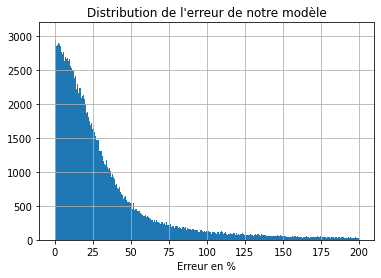

In [14]:
shema=pd.DataFrame((np.abs(y_test-forest.predict(X_test))/y_test))*100
shema[shema<200].hist(bins=1000)
plt.xlabel('Erreur en %')
plt.title('Distribution de l\'erreur de notre modèle')

In [15]:
shema.iloc[0].astype(float).median()


13.010011591701367

In [17]:
# Save model RandomForest
from sklearn.externals import joblib

# Save to file in the current working directory
joblib_file = "/content/drive/MyDrive/data_pa/model_immo_maison_full_region_13err.pkl"
joblib.dump(forest, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

print(X[1], y[1])
joblib_model.predict([X[1]])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[-7.22401806 -8.8194302   1.73050914 -2.24189692 -0.06540547] 1278


array([1757.84196429])

Xgboost

In [ ]:
# fit a final xgboost model on the housing dataset and make a prediction
from numpy import asarray
from pandas import read_csv
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
df_ml['code_region']=encoder.fit_transform(df_ml['code_region'])

y = df_ml['prix_metre_carre'].values
X = df_ml.drop(columns=['prix_metre_carre']).values

# define model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# fit model
model.fit(X, y)
# define new data
row = X[0]
new_data = asarray([row])
# make a prediction
yhat = model.predict(new_data)
# summarize prediction
print(X[0])
print(y[0])

print('Predicted: %.3f' % yhat)


Keras

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
df_ml['code_region']=encoder.fit_transform(df_ml['code_region'])

y = df_ml['prix_metre_carre'].values
X = df_ml.drop(columns=['prix_metre_carre']).values
print(y)

[  42   95 3916 ... 4423 4952  964]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# model = tf.keras.models.Sequential()

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.tanh))
# model.add(tf.keras.layers.Dense(128, activation=tf.keras.activations.tanh))
# model.add(tf.keras.layers.Dense(32, activation=tf.keras.activations.tanh))

# model.compile(
#         optimizer=tf.keras.optimizers.Adam(),
#         loss=tf.keras.losses.MeanSquaredError(),
#         metrics=tf.keras.metrics.categorical_accuracy
#       )

model = tfdf.keras.RandomForestModel()
history = model.fit(
        X,
        y
    )


4575/4575 [==============================] - 8s 874us/step


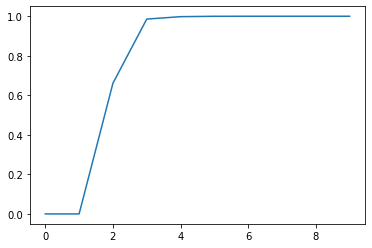

In [ ]:
plt.plot(history.history['categorical_accuracy'])

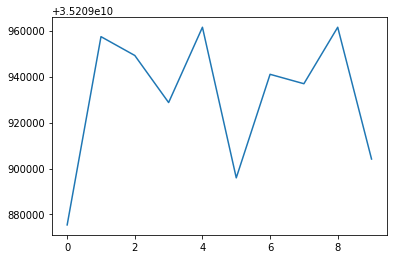

In [ ]:
plt.plot(history.history['loss'])